In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import cv2
import sys

sys.path.append('..')
from src.modules.srgan.data_utils import read_img_hpa, ImageStacker, HPATrainDatasetFromFolder, \
    RecursionTrainDatasetFromFolder, RecursionValDatasetFromFolder, HPAValDatasetFromFolder, HPATrainDatasetFromFolder
from src.modules.pix2pix.colorization_model import ColorizationModel
from src.utils.cell_segmentation import label_cells
from src.configs.config import train_pix2pix_options, merge_opts
from torch.utils.data import DataLoader

In [15]:
def show_tensor(t, pixel_scale=100):
    img = np.transpose(t.numpy(), (1,2,0))
    f = plt.figure(figsize=(int(img.shape[1] / pixel_scale), int(img.shape[0] / pixel_scale)))
    plt.imshow(img, interpolation='nearest')
    plt.show()
    
def get_dataloaders(train_data_dir, valid_data_dir, opt):
    if opt.dataset_type == 'hpa':
        train_set = HPATrainDatasetFromFolder(
            train_data_dir, crop_size=opt.crop_size,
            upscale_factor=1, colorisation=True,
            merged_channels=opt.merged_channels,
            normalization=opt.dataset_norm)
        val_set = HPAValDatasetFromFolder(
            valid_data_dir, upscale_factor=1,
            colorisation=True,
            merged_channels=opt.merged_channels,
            normalization=opt.dataset_norm)
        
    elif opt.dataset_type == 'rx':
        train_set = RecursionTrainDatasetFromFolder(
            train_data_dir, crop_size=opt.crop_size,
            upscale_factor=1, colorisation=True, merged_channels=opt.merged_channels)
        val_set = RecursionValDatasetFromFolder(
            valid_data_dir, upscale_factor=1,
            colorisation=True, merged_channels=opt.merged_channels)
        
    else:
        raise ValueError('Unknown dataset type ' + dataset_type)
        
    train_loader = DataLoader(dataset=train_set, num_workers=opt.num_workers,
                              batch_size=opt.batch_size, shuffle=True)
    val_loader = DataLoader(dataset=val_set, num_workers=8, batch_size=1, shuffle=False)
    return train_loader, val_loader

def get_dataloaders_args(train_data_dir, valid_data_dir, **kwargs):
    return get_dataloaders(train_data_dir, valid_data_dir,
                           merge_opts(train_pix2pix_options, kwargs))

# MEL Science Microscope: ML workstream

## Abstract

The purpose of this work process was to investigate possibilities of applying ML methods (particularly, deep learning) for enhancing the experience of MEL Microscope user (a student).

## Work directions

As the project idea developed, the three desired potential features which could be leveraged by deep learning has been stated:

- Super-resolution (zooming the image further than optical capabilities of the microscope and constructing a plausible detalization
- Organelle segmentation/colorization (determining where the different functional parts of the cells are)
- Classification (determining the type of cell/microorganism on the image)

The work has been performed using the following open datasets:
- Human Protein Atlas Image Classification (HPA): https://www.kaggle.com/c/human-protein-atlas-image-classification/
- Recursion Cellular Image Classification (RX): https://www.kaggle.com/c/recursion-cellular-image-classification/data
- Plankton Set 1.0: https://data.nodc.noaa.gov/cgi-bin/iso?id=gov.noaa.nodc:0127422

## 1. Super-resolution

For super-resolution, we applied an SRGAN model (https://arxiv.org/abs/1609.04802) with the following differences:
- The network receives a grayscale one-channel image as an input instead of RGB image
- We use gradient clipping
- We don't use the perception loss obtained from pretrained VGG19 model, since there are little perceptual similarities between ImageNet samples and microscopic images.

Also, during the training, we've encountered the problem of prevalence of empty background in the image samples. The original SRGAN training procedure uses small random crops of training set images as inputs, and a large fraction of such random crops turned out to be mostly black. This resulted in training the model which simply yielded empty background as an output all the time.

We combated this problem by preprocessing the dataset beforehand and marking the positions of cell nuclei (assuming that the available dataset have separate channel for nuclei, both HPA and RX datasets have).

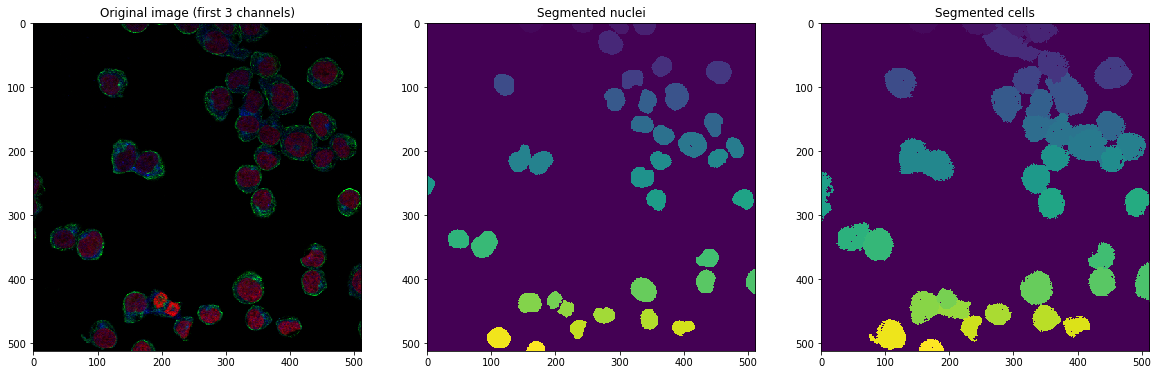

In [16]:
sample_img = read_img_hpa('../data/hpa/valid/ffced1a2-bbad-11e8-b2ba-ac1f6b6435d0_{}.png')
centroids, cells = label_cells(sample_img, make_cells_masks=True)
fig, axes = plt.subplots(1, 3, figsize=(20, 10))
axes[0].imshow(sample_img[:, :, :3])
axes[0].set_title('Original image (first 3 channels)')
axes[1].imshow(centroids)
axes[1].set_title('Segmented nuclei')
axes[2].imshow(cells)
axes[2].set_title('Segmented cells')
plt.show()

We save the nuclei segmentation map (middle image above) for each image in the training set, and then choose the crops which contain at least one nucleus.

Here are the results of grayscale SRGAN, trained on HPA dataset in 8 epochs:

## 2. Organelle colorization

initialize network with normal
loading the model from ../pix2pix_training/kek_unet128/latest_net_G.pth
---------- Networks initialized -------------
[Network G] Total number of parameters : 41.824 M
-----------------------------------------------


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


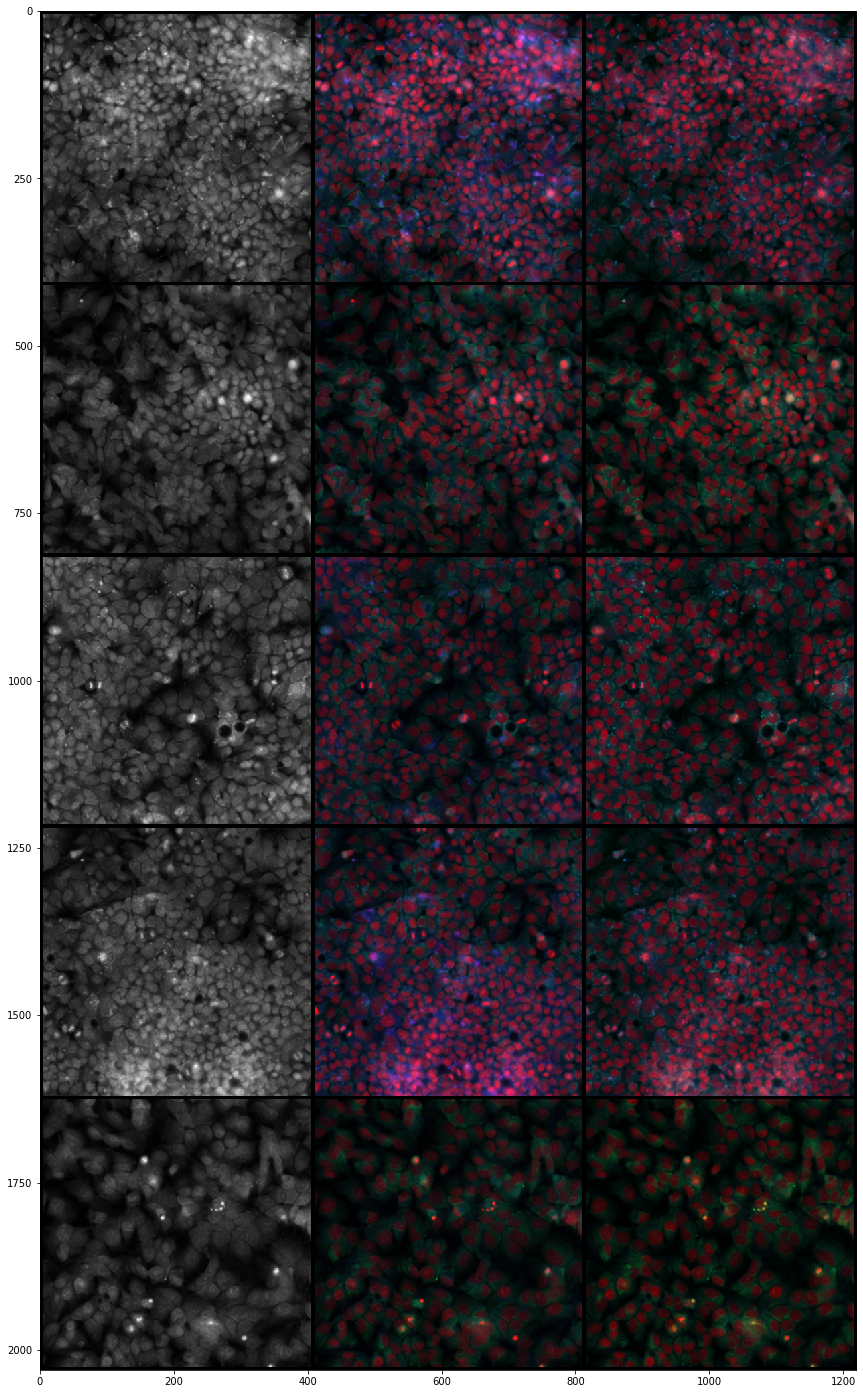

In [19]:
_, v_loader = get_dataloaders_args(
    '../data/rx/valid', '../data/rx/valid', dataset_type='rx',
    merged_channels=['actin', 'nucleoli', 'mitochondria', 'golgi'],
    dataset_norm=True)

opts = merge_opts(train_pix2pix_options, {
    'name':'kek_unet128',
    'netG': 'unet_128',
    'isTrain': False,
    'gpu_ids': []
})
color_model = ColorizationModel(opts)
color_model.setup(opts)
color_model.eval()

stacker = ImageStacker(3, 5)
data_iter = iter(v_loader)

for i in range(0, 5):
    val_gray_one, val_gray, val_color = next(data_iter)
    color_model.set_input({'A': val_gray_one, 'B': val_color, 'A_paths': [], 'B_paths': []})
    color_model.test()
    val_result = color_model.fake_B
    stacker.add_row(val_gray, val_color, val_result)

for grid in stacker.grids():
    show_tensor(grid, pixel_scale=80)

## 3. Microorganism classification/detection